## RFV

A análise RFV pode ser uma peça crucial para a otimização dos lucros de uma empresa. Os clientes são classificados em relação a:

- **Recência:** Quanto tempo realizaram uma compra.
- **Frequência:** Com que frequência fazem compras.
- **Valor:** Quanto dinheiro gastam em cada compra.

Esse tipo de análise permite que empresas desenvolvam estratégias de marketing personalizado, otimizando ainda mais os lucros ao entender o comportamento de seus clientes. Um trabalho que pode ser realizado em conjunto com equipes de data science e marketing pode fazer com que o lucro de uma empresa cresça exponencialmente.


In [565]:
# Pacotes de preparação dos dados
import numpy as np
import pandas as pd
import calendar
from datetime import datetime
# Pacotes gráficos
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Pacotes de modelagem
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

In [566]:
dados = pd.read_csv('dados/data.csv', encoding='latin1')


### Features do dataset


- **InvoiceNo:** Número único associado a cada fatura (transação) no conjunto de dados.

- **StockCode:** Código único associado a cada produto ou item em estoque.

- **Description:** Descrição do produto ou item correspondente ao StockCode.

- **Quantity:** A quantidade de unidades do produto ou item incluídas em uma transação.

- **InvoiceDate:** Data e horário em que a transação foi registrada.

- **UnitPrice:** Preço unitário de cada produto ou item.

- **CustomerID:** Identificador único associado a cada cliente.

- **Country:** País de origem do cliente ou local da transação.


## Análise Inicial dos Dados

In [567]:
dados.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


In [568]:
dados.isnull().mean()

InvoiceNo      0.000000
StockCode      0.000000
Description    0.002683
Quantity       0.000000
InvoiceDate    0.000000
UnitPrice      0.000000
CustomerID     0.249267
Country        0.000000
dtype: float64

In [569]:
dados.duplicated().sum()

5268

In [570]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [571]:
dados.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


## Tratamento dos dados

In [572]:

dados['InvoiceDate'] = pd.to_datetime(dados['InvoiceDate'])

In [573]:
dados['Revenue'] = dados['Quantity'] * dados['UnitPrice']

In [574]:
dados = dados.query('Quantity > 0 and UnitPrice > 0')
dados = dados[dados['CustomerID'].notna()]
dados.shape

(397884, 9)

In [575]:
dados['Quantiles'] = pd.qcut(dados.Revenue, 5)
dados['Percentile_sort'] = dados.Revenue.rank(pct= True)
dados['Rank'] = dados.Revenue.rank()
dados.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Quantiles,Percentile_sort,Rank
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,"(15.0, 20.8]",0.624769,248585.5
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,"(15.0, 20.8]",0.787735,313427.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,"(20.8, 168469.6]",0.811120,322731.5
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,"(15.0, 20.8]",0.787735,313427.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,"(15.0, 20.8]",0.787735,313427.0


In [576]:
recency = (dados[['CustomerID', 'InvoiceDate']].groupby('CustomerID')['InvoiceDate']).agg('max').reset_index()
recency.head(10)

,CustomerID,InvoiceDate
0,12346.0,2011-01-18 10:01:00
1,12347.0,2011-12-07 15:52:00
2,12348.0,2011-09-25 13:13:00
3,12349.0,2011-11-21 09:51:00
4,12350.0,2011-02-02 16:01:00
5,12352.0,2011-11-03 14:37:00
6,12353.0,2011-05-19 17:47:00
7,12354.0,2011-04-21 13:11:00
8,12355.0,2011-05-09 13:49:00
9,12356.0,2011-11-17 08:40:00


In [577]:
''' Essa função calcula a diferença em meses, onde curl_time representa a data mais recente. 
    A função recebe uma data (date_value) como parâmetro e determina a diferença em meses entre a data mais recente (curl_time) 
    e a data fornecida, transformando essa diferença em meses.
'''
curl_time = recency.InvoiceDate.max()

def month_transform(curl_time, date_value):
   return 12 * (curl_time.year - date_value.year) +  (curl_time.month - date_value.month)


In [578]:
print(curl_time)

2011-12-09 12:50:00


In [579]:
# Criando uma coluna 'Recency' com o cálculo da recência usando a função month_transform
recency['Recency'] = recency.InvoiceDate.apply(lambda date_value: month_transform(curl_time, date_value))
recency.head()

,CustomerID,InvoiceDate,Recency
0,12346.0,2011-01-18 10:01:00,11
1,12347.0,2011-12-07 15:52:00,0
2,12348.0,2011-09-25 13:13:00,3
3,12349.0,2011-11-21 09:51:00,1
4,12350.0,2011-02-02 16:01:00,10


# Análise Exploratória dos Dados
## Análise da Distribuição de Recência dos Clientes

O boxplot abaixo fornece uma análise da distribuição da recência dos clientes, revelando comportamentos importantes.

## Comportamentos Observados

- **Mediana e Média:**
  - A mediana da recência dos clientes, representada pela linha vermelha tracejada, está em torno de 2 meses.
  - A média de retorno dos clientes é de aproximadamente 3 meses, indicando que, em média, os clientes apresentam um ciclo de compra a cada 3 meses.

- **Tendência Central:**
  - A mediana fornece uma medida robusta da tendência central e sugere que a maioria dos clientes retorna em torno desse período de tempo.


## Conclusões Preliminares

O box plot descreve alguns comportamentos notáveis na recência dos clientes. A média sugerem que a maioria dos clientes tende a retornar em aproximadamente 3 meses. É possível identificar alguns outliers, representando clientes que não realizam compras há bastante tempo, apresentando uma alta recência. Para esse tipo de cliente, estratégias específicas podem ser consideradas, como campanhas direcionadas de reativação, lembretes personalizados, e até mesmo a implementação de um bot em aplicativos de mensagens para enviar esse tipo de lembrete, entre outras estratégias.



In [580]:

fig = go.Figure()

# Create the box plot
fig.add_trace(go.Box(
    y=recency['Recency'],
    boxpoints='outliers',
    marker_color='#77AADD',
    line_color='black'
))

# Add horizontal lines for median and mean
fig.add_hline(y=recency['Recency'].median(), line_dash='dash', line_color='red', annotation_text='Median: {}'.format(recency['Recency'].median()), annotation_position='bottom right')
fig.add_hline(y=recency['Recency'].mean(), line_dash='dash', line_color='green', annotation_text='Mean: {:.2f}'.format(recency['Recency'].mean()), annotation_position='bottom right')

# Customize layout
fig.update_layout(
    title='Distribuição de Recência dos Clientes',
    yaxis_title='Recency (Meses)',
    margin=dict(l=15, r=15, t=30, b=30),
    hovermode='x'
)

# Display the plot
fig.show()


In [581]:
recency['Recency'].describe()

count    4338.000000
mean        3.222453
std         3.284536
min         0.000000
25%         1.000000
50%         2.000000
75%         5.000000
max        12.000000
Name: Recency, dtype: float64

## Distribuição de Recência dos Clientes

Ao analisar o gráfico, é possível notar que a maioria dos clientes está há menos de 6 meses sem comprar. Isso indica que a empresa está mantendo um bom relacionamento com os clientes.

No entanto, há um número significativo de clientes que estão há mais de 6 meses sem comprar. Esses clientes podem estar insatisfeitos com a empresa ou podem ter encontrado opções melhores com preços mais acessíveis.

Esses dados podem ser úteis na criação de campanhas de marketing, especialmente para os clientes que estão há muito tempo sem comprar na empresa, evitando um possível churn.


In [619]:
import plotly.express as px

# Assuming you have the DataFrame 'df_recency' with a 'Recency' column
data = recency['Recency'].value_counts().reset_index(name='Count')  # Remove sorting to include all numbers

fig = px.bar(data, x='Recency', y='Count', title='Customer Recency Distribution')

# Adjust axis labels, title, colors, etc.
fig.update_layout(
    xaxis_title='Meses Desde a Última Compra',
    yaxis_title='Número de Clientes',
    title='Distribuição de Recência dos Clientes',
    coloraxis_colorbar=dict(title='Número de Clientes')  # If using color-coding
)

# Use a bolder color palette
fig.update_traces(marker_color='rgb(255, 153, 51)')  # Orange

fig.show()



In [583]:
recency = recency.drop('InvoiceDate', axis=1)
recency.head()

,CustomerID,Recency
0,12346.0,11
1,12347.0,0
2,12348.0,3
3,12349.0,1
4,12350.0,10


In [584]:
recency.head()

,CustomerID,Recency
0,12346.0,11
1,12347.0,0
2,12348.0,3
3,12349.0,1
4,12350.0,10


In [585]:
df_rm = dados[['CustomerID','InvoiceNo', 'Revenue']] 

In [586]:
df_rm = df_rm.groupby('CustomerID')[['InvoiceNo', 'Revenue']].agg({'Revenue': 'mean', 'InvoiceNo': 'count'}).reset_index()
df_rm = df_rm.rename(columns={'InvoiceNo': 'Frequency', 'Revenue': 'Monetary'})

df_rm['Monetary'] = df_rm['Monetary'].round(2)


In [587]:
df_rm.head()

,CustomerID,Monetary,Frequency
0,12346.0,77183.60,1
1,12347.0,23.68,182
2,12348.0,57.98,31
3,12349.0,24.08,73
4,12350.0,19.67,17


In [588]:
recency.head()

,CustomerID,Recency
0,12346.0,11
1,12347.0,0
2,12348.0,3
3,12349.0,1
4,12350.0,10


In [589]:
rfv = recency.merge(df_rm,on="CustomerID", how="left")
rfv = rfv.fillna(0)
rfv.head()

,CustomerID,Recency,Monetary,Frequency
0,12346.0,11,77183.60,1
1,12347.0,0,23.68,182
2,12348.0,3,57.98,31
3,12349.0,1,24.08,73
4,12350.0,10,19.67,17


In [590]:
# Padronizando todos os dados na mesma escala, o que é importante porque o K-means trabalha com distâncias


# feature columns
feature_cols = ['Recency', 'Frequency', 'Monetary']

# DataFrame for training
standardized_data = rfv.copy()

Prepocessing_pipe = Pipeline([('scaler', MinMaxScaler())])

standardized_data[feature_cols] = Prepocessing_pipe.fit_transform(rfv[feature_cols])


In [591]:
# Criando uma função para treinar o modelo

def model_kmeans(standardized_data, k):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(standardized_data[feature_cols])

    return kmeans


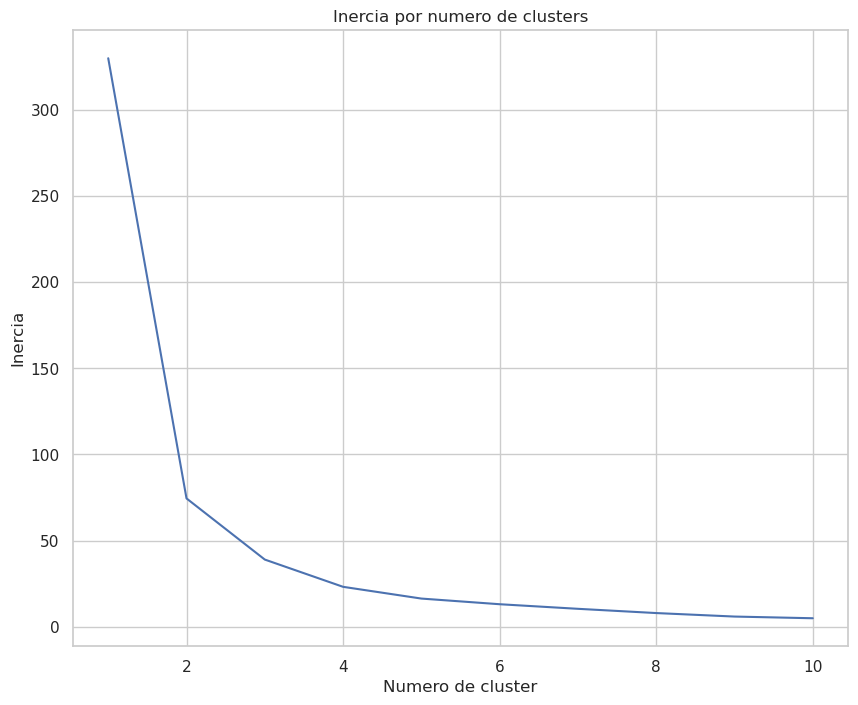

In [592]:
range_cluster = np.arange(1,11)
inercia = []
n_cluster = []

for num_cluster in range_cluster:
    n_cluster.append(num_cluster)
    modelo = model_kmeans(standardized_data, k=num_cluster,)

    inercia.append(modelo.inertia_)

fig = plt.figure(figsize=(9,8))
plot = sns.lineplot(x=n_cluster, y=inercia)
plot.set_title('Inercia por numero de clusters')
plot.set_xlabel('Numero de cluster')
plot.set_ylabel('Inercia')
plt.show()

In [593]:
modelo_final = model_kmeans(standardized_data, 4)
rfv['Clusters'] = modelo_final.labels_


In [594]:
analise_centroid = (rfv.groupby('Clusters')[['CustomerID', 'Recency', 'Monetary', 'Frequency']].agg({
    'CustomerID':'nunique',
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':'mean'

}).reset_index())
analise_centroid =analise_centroid.rename(columns={'CustomerID':'Qtd_compradores'})


In [595]:

analise_centroid.sort_values(by='Recency', ascending=True)

,Clusters,Qtd_compradores,Recency,Frequency,Monetary
0,0,1908,0.677673,151.766771,61.197075
2,2,1280,2.658594,57.774219,33.723898
3,3,661,6.394856,34.396369,62.603253
1,1,489,10.339468,23.775051,194.668507


## Análise de Recência por Cluster

**Cluster 0: Ativos e Engajados:**
O Cluster 0 apresenta a menor média de recência, indicando que os clientes desse grupo são valiosos para a empresa, pois tendem a comprar em intervalos curtos de tempo.


**Cluster 1: Necessidade de Reativação:**
Este cluster possui a maior média de recência, indicando clientes que precisam de atenção para possível reativação.


**Cluster 2: Clientes Leais e Frequentes:**
Com recência baixa, um pouco maior que o Cluster 0, esses clientes demonstram lealdade e frequência nas compras.


**Cluster 3: Recência Mediana:**
Clientes não tão frequentes, mas que tendem a retornar em intervalos de tempo mais longos.



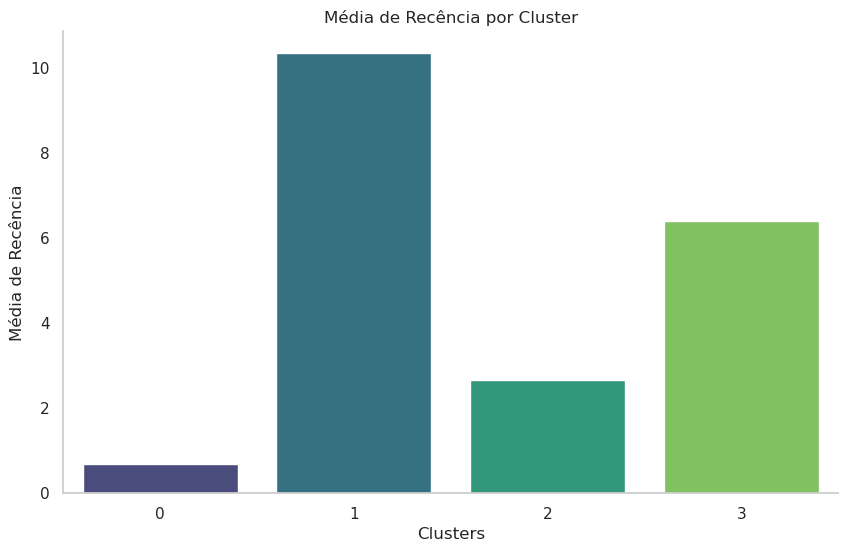

In [612]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6), facecolor='w', edgecolor='k', alpha=0.7) 
palette = sns.color_palette("viridis", n_colors=len(analise_centroid['Clusters']))

sns.barplot(x='Clusters', y='Recency', data=analise_centroid, palette=palette)
plt.title('Média de Recência por Cluster')
plt.xlabel('Clusters')
plt.ylabel('Média de Recência')
sns.despine(top=True, right=True)  
plt.grid(False)  
plt.show()
plt.show()


## Análise de Frequência por Cluster

**Cluster 0: Maior Frequência:**
Assim como uma baixa recência, o Cluster 0 possui uma alta frequência, indicando que esse cluster contém os clientes mais importantes. É necessário manter esses clientes, pois possivelmente contribuem significativamente para os lucros da empresa.


**Cluster 1: Necessidade de Reativação:**
Possui alta recência e baixa frequência, indicando que o Cluster 1 possui os clientes menos engajados. É necessário entender os motivos por trás da baixa frequência e alta recência.


**Cluster 2: Clientes Leais:**
Possui a segunda maior frequência, não tão alta, mas indicando que no Cluster 2 existem clientes importantes. É possível adotar estratégias para aumentar a frequência.


**Cluster 3: Baixa Frequência:**
Frequência maior que a do Cluster 1, porém menor que a do Cluster 2. Estratégias para incentivar compras mais frequentes incluem ofertas de promoções, mensagens oferecendo produtos novos e a identificação dos itens que os clientes desse cluster tendem a comprar.


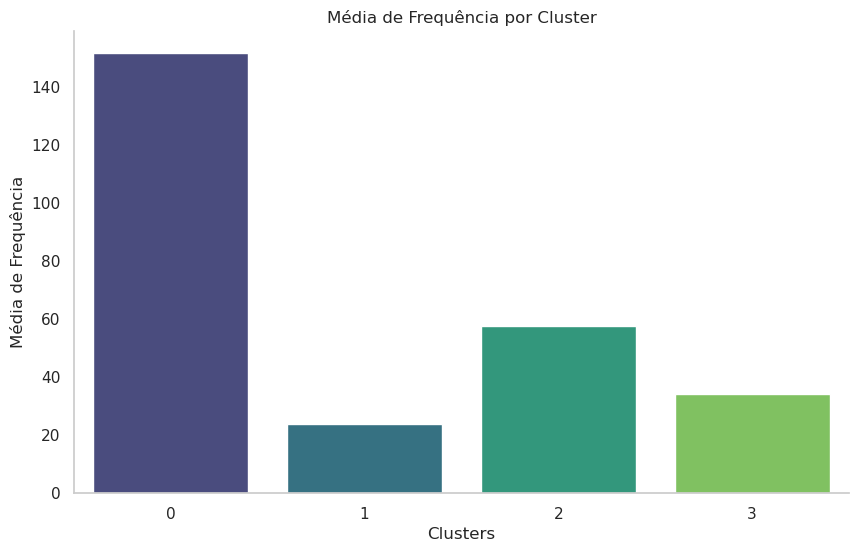

In [609]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6), facecolor='w', edgecolor='k', alpha=0.7) 
palette = sns.color_palette("viridis", n_colors=len(analise_centroid['Clusters']))

sns.barplot(x='Clusters', y='Frequency', data=analise_centroid, palette=palette)
plt.title('Média de Frequência por Cluster')
plt.xlabel('Clusters')
plt.ylabel('Média de Frequência')
sns.despine(top=True, right=True)  
plt.grid(False)  
plt.show()

## Análise da Média de Valor Monetário por Cluster

**Cluster 0: Moderado em Valor Monetário**
Apesar de ter a menor recência média e a maior frequência, o gasto médio não é tão alto.

**Cluster 1: Maior Recência e Maior Gasto**
Apesar da maior recência média e menor frequência, este cluster é o que mais gasta. 

**Cluster 2: Moderado em Recência e Gasto**
Este cluster possui uma média equilibrada de recência e frequência, mas o gasto médio não é muito alto.

**Cluster 3: Menor Recência e Gasto**
Apesar de ter uma recência média menor e uma frequência intermediária, o gasto médio não é tão elevado.


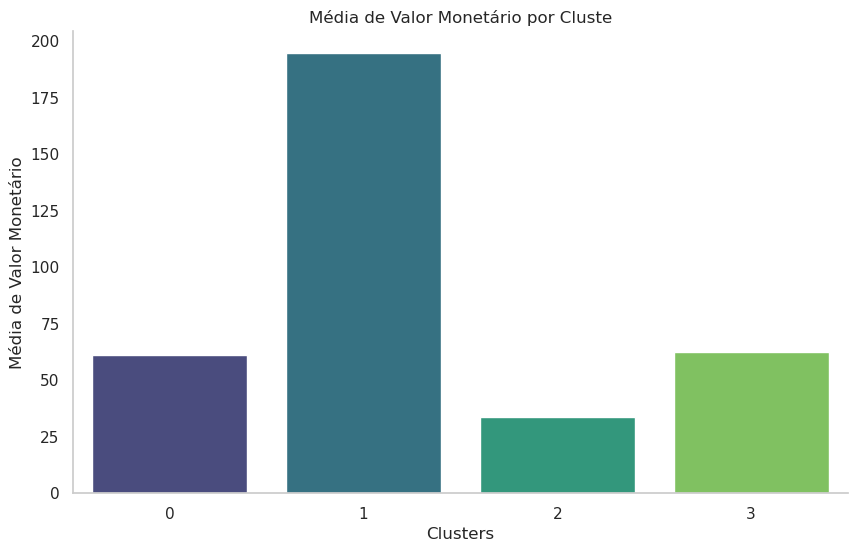

In [613]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6), facecolor='w', edgecolor='k', alpha=0.7) 
palette = sns.color_palette("viridis", n_colors=len(analise_centroid['Clusters']))

sns.barplot(x='Clusters', y='Monetary', data=analise_centroid, palette=palette)
plt.title('Média de Valor Monetário por Cluste')
plt.xlabel('Clusters')
plt.ylabel('Média de Valor Monetário')
sns.despine(top=True, right=True)  
plt.grid(False)  
plt.show()

In [618]:
name_cluster = [
    'frequentes_economicos',
    'maior_gasto',
    'constantes_moderados',
    'oportunidade_crescimento'
]

analise_centroid['Segmentação'] = name_cluster
analise_centroid.head()

,Clusters,Qtd_compradores,Recency,Frequency,Monetary,Segmentação
0,0,1908,0.677673,151.766771,61.197075,frequentes_economicos
1,1,489,10.339468,23.775051,194.668507,maior_gasto
2,2,1280,2.658594,57.774219,33.723898,constantes_moderados
3,3,661,6.394856,34.396369,62.603253,oportunidade_crescimento


# Conclusão e Possíveis Estratégias

A análise de cluster permitiu identificar quatro grupos de clientes com características distintas. As estratégias a seguir podem ser adotadas para melhorar a experiência desses clientes e aumentar a lucratividade da empresa:

## Cluster 0: "Frequentes, Recentes e Econômicos"

* **Características:** Maior frequência, menor recência, mas gasto médio baixo.
* **Possíveis Estratégias:**
    * Oferecer novos produtos que possam atrair interesse frequente.
    * Implementar um programa de fidelidade para recompensar a lealdade desses clientes.

## Cluster 1: "Esporádicos, Recentes e Valiosos"

* **Características:** Baixa frequência, alta recência, mas gasto elevado.
* **Possíveis Estratégias:**
    * Identificar padrões de compra para personalizar promoções.
    * Enviar mensagens com ofertas específicas com base nas tendências de compra.
    * Estratégias de marketing em datas comemorativas para oferecer produtos relevantes.

## Cluster 2: "Constantes e Moderados"

* **Características:** Recência baixa, frequência mediana.
* **Possíveis Estratégias:**
    * Adotar estratégias semelhantes ao Cluster 0, como comunicação personalizada.
    * Enviar promoções segmentadas com base nas preferências de compra.

## Cluster 3: "Recência Intermediária e Gasto Moderado"

* **Características:** Recência média menor, frequência intermediária, gasto médio.
* **Possíveis Estratégias:**
    * Analisar padrões de compra para entender preferências.
    * Oferecer produtos específicos por meio de aplicativos de mensagens para otimizar a frequência de compra.
    * Estratégias para aumentar o valor médio das compras.

### Entender o comportamento de seus clientes é uma peça fundamental para obter maior lucro. Se você sabe qual cliente compra mais, pode criar estratégias para fidelizá-lo. Você também pode analisar possíveis churns de clientes. Entender seu público é uma peça fundamental, pois pode te levar a um passo à frente de seus concorrentes.
